In [8]:
import networkx as nx
from networkx.algorithms import *
import numpy as np
import matplotlib
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.pyplot as plt
from libpysal.cg import voronoi_frames
import os

# Graph stat funcs

In [2]:
def degree_analysis(graph):

    print(f"Nodes: {len(graph.nodes)}")
    print(f"Links: {len(graph.edges)}")

    in_degree_sequence = sorted((d for n, d in graph.in_degree()), reverse=True)
    out_degree_sequence = sorted((d for n, d in graph.out_degree()), reverse=True)

    k_in, t_in = np.unique(in_degree_sequence, return_counts=True)
    k_out, t_out = np.unique(out_degree_sequence, return_counts=True)
    N_in, N_out = np.sum(t_in), np.sum(t_out)
    p_k_in, p_k_out = t_in/N_in, t_out/N_out

    print(f"Average Incoming Degree: {np.sum(k_in*p_k_in)}")
    print(f"Average Outgoing Degree: {np.sum(k_out*p_k_out)}")

    fig = plt.figure("Degree Analysis", figsize=(8, 8))

    axgrid = fig.add_gridspec(2, 2)

    ax1 = fig.add_subplot(axgrid[0, 0])
    ax1.bar(k_in, p_k_in)
    ax1.set_xlabel("k_in")
    ax1.set_ylabel("degree distribution")
    plt.grid()
    plt.xlim([-0.5, max(in_degree_sequence)])
    plt.ylim([0, 1])
    plt.xticks(np.arange(min(in_degree_sequence), max(in_degree_sequence) + 1, 1.0))
    plt.yticks(np.arange(0, 1+0.05, 0.1))

    ax2 = fig.add_subplot(axgrid[0, 1])
    ax2.scatter(k_in, p_k_in, s=100)
    ax2.set_xlabel("k_in")
    ax2.set_ylabel("degree distribution")
    ax2.set_yscale('log')

    plt.xlim([-0.5, max(in_degree_sequence)+0.5])
    plt.ylim([0.0001, 1])
    plt.grid()
    plt.xticks(np.arange(min(in_degree_sequence), max(in_degree_sequence) + 1, 1.0))

    ax3 = fig.add_subplot(axgrid[1, 0])
    ax3.bar(k_out, p_k_out)
    ax3.set_xlabel("k_out")
    ax3.set_ylabel("degree distribution")
    plt.grid()
    plt.xlim([-0.5, max(out_degree_sequence)])
    plt.ylim([0, 1])
    plt.xticks(np.arange(min(out_degree_sequence), max(out_degree_sequence) + 1, 1.0))
    plt.yticks(np.arange(0, 1 + 0.05, 0.1))

    ax4 = fig.add_subplot(axgrid[1, 1])
    ax4.scatter(k_out, p_k_out, s=100)
    ax4.set_xlabel("k_out")
    ax4.set_ylabel("degree distribution")
    ax4.set_yscale('log')

    plt.xlim([-0.5, max(out_degree_sequence) + 0.5])
    plt.ylim([0.0001, 1])
    plt.xticks(np.arange(min(out_degree_sequence), max(out_degree_sequence) + 1, 1.0))

    fig.tight_layout()
    plt.grid()
    plt.savefig('degree_analysis.png')
    plt.show()

    _plot_map_degree(graph)


def _plot_map_degree(graph):

    graph_coloring = coloring.greedy_color(graph, strategy='largest_first')

    for key, value in graph_coloring.items():
        graph.nodes[key]['color'] = value

    H = nx.Graph()
    H.add_nodes_from(sorted(graph.nodes(data=True), key=lambda x: x[1]['color']))
    H.add_edges_from(graph.edges(data=True))

    pos = {n[0]: (n[1]['y'], n[1]['x']) for n in H.nodes(data=True)}
    colors_raw = [n[1]['color']+1 for n in H.nodes(data=True)]

    colors = list(map(lambda x: x/max(colors_raw), colors_raw))

    norm = matplotlib.colors.LogNorm(vmin=min(colors), vmax=max(colors))

    plt.figure(figsize=(14, 10), dpi=300)
    nx.draw(H, pos, node_size=list(map(lambda x: x**3, colors_raw)), node_color=norm(colors), arrowsize=1, edge_color='#ddd',
            cmap=plt.cm.GnBu)
    # plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.axis("off")
    plt.savefig('map_degree.png')
    plt.show()


def connected_components_analysis(graph):

    print(f"Is Strongly Connected: {nx.is_strongly_connected(graph)}")
    print(f"Is Weakly Connected: {nx.is_weakly_connected(graph)}")

    strongly_connected_components = list(sorted(nx.strongly_connected_components(graph), key=len, reverse=True))

    #strongly_connected_components = [c for c in strongly_connected_components if len(c) > 1]

    S = [G.subgraph(c).copy() for c in strongly_connected_components]

    print(f"Components Size: {[len(c) for c in S]}")
    print(f"Diameter of Largest Component: {nx.diameter(S[0])}")

    colors = list(range(len(strongly_connected_components)))
    color_id = 0
    for c in strongly_connected_components:
        color = colors[color_id]
        for n in c:
            graph.nodes[n]['color'] = color
        color_id += 1

    pos = {n[0]: (n[1]['y'], n[1]['x']) for n in graph.nodes(data=True)}

    node_color = []
    for n in graph.nodes(data=True):
        node_color.append(n[1]['color'])

    fig = plt.figure(figsize=(14, 10), dpi=300)
    ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
    imagery = OSM()
    ax.set_extent([-0.14, -0.1, 51.495, 51.515], ccrs.PlateCarree())
    ax.add_image(imagery, 14)

    nx.draw(graph, pos, node_size=5, node_color=node_color, arrowsize=3, vmin=1, vmax=6, edge_color='#ccc',
            cmap=plt.cm.Set1)
    # plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.axis("off")
    plt.show()

    _plot_map_connected(graph)


def _plot_map_connected(graph):
    graph = graph.to_undirected()
    graph_coloring = coloring.greedy_color(graph, strategy='connected_sequential_bfs')

    for key, value in graph_coloring.items():
        graph.nodes[key]['color'] = value

    H = nx.Graph()
    H.add_nodes_from(sorted(graph.nodes(data=True), key=lambda x: x[1]['color']))
    H.add_edges_from(graph.edges(data=True))

    pos = {n[0]: (n[1]['y'], n[1]['x']) for n in H.nodes(data=True)}
    colors_raw = [n[1]['color']+1 for n in H.nodes(data=True)]

    colors = list(map(lambda x: x/max(colors_raw), colors_raw))

    plt.figure(figsize=(14, 10), dpi=300)
    nx.draw(H, pos, node_size=list(map(lambda x: x**3, colors_raw)), edge_color='#ddd', node_color=colors,
            arrowsize=1, cmap=plt.cm.GnBu)
    # plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def bridge_analysis(graph):

    graph = graph.to_undirected()

    graph_bridges = list(nx.bridges(graph))

    print(f"Has Bridges: {'Yes' if len(graph_bridges) > 0 else 'No'} - How many: {len(graph_bridges)}")

    colors = []
    for b in graph.edges:
        color = 'r' if b in graph_bridges else '#ccc'
        colors.append(color)

    pos = {n[0]: (n[1]['y'], n[1]['x']) for n in graph.nodes(data=True)}

    plt.figure(figsize=(14, 10), dpi=300)
    nx.draw(graph, pos, node_size=3, node_color="b", arrowsize=3, edge_color=colors)
    # plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def spanning_tree(graph):
    graph_undirected = graph.to_undirected()

    tree_graph = nx.minimum_spanning_tree(graph_undirected)

    pos = {n[0]: (n[1]['y'], n[1]['x']) for n in tree_graph.nodes(data=True)}

    plt.figure(figsize=(14, 10), dpi=300)
    nx.draw(tree_graph, pos, node_size=3, node_color="b", arrowsize=3, edge_color='#ccc')
    # plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def voronoi_cells(graph):

    lat = []
    lon = []
    for n in graph.nodes(data=True):
        lat.append(n[1]['y'])
        lon.append(n[1]['x'])

    coordinates = np.column_stack((lat, lon))
    cells, _ = voronoi_frames(coordinates, clip="convex hull")
    cells["area"] = 1/cells['geometry'].area

    norm = matplotlib.colors.LogNorm(vmin=cells["area"].min(), vmax=cells["area"].max())

    fig = plt.figure(figsize=(14, 10), dpi=300)
    ax = fig.add_subplot(111)
    cells.plot(cmap=plt.cm.Spectral_r, column='area', edgecolor='white', linewidth=1, ax=ax, norm=norm)
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.axis("off")
    plt.show()


def betweeness_centrality(graph):
    graph = graph.to_undirected()

    centrality = nx.betweenness_centrality(graph, endpoints=True, seed=1)

    lpc = nx.community.label_propagation_communities(graph)
    community_index = {n: i for i, com in enumerate(lpc) for n in com}

    fig, ax = plt.subplots(figsize=(14, 10))
    pos = {n[0]: (n[1]['y'], n[1]['x']) for n in graph.nodes(data=True)}
    node_color = [community_index[n] for n in graph]
    node_size = [v * 8000 for v in centrality.values()]
    nx.draw_networkx(
        graph,
        pos=pos,
        with_labels=False,
        node_color=node_color,
        node_size=node_size,
        edge_color="gainsboro",
        alpha=0.4,
        cmap=plt.cm.Dark2
    )

    plt.gca().invert_xaxis()
    fig.tight_layout()
    plt.axis("off")
    plt.show()


def plot(graph):
    plt.figure(figsize=(14, 10), dpi=300)

    pos = {n[0]: (n[1]['y'], n[1]['x']) for n in graph.nodes(data=True)}

    nx.draw(graph, pos, node_size=3, node_color="b", arrowsize=3, edge_color='#ccc')
    # plt.gca().invert_yaxis()
    plt.gca().invert_xaxis()
    plt.tight_layout()
    plt.axis("off")
    plt.show()

# Studying additional graph analysis

In [9]:
def plot_study(graph, attr_name):
    plt.rcParams["figure.facecolor"] = "grey"
    plt.figure(figsize=(50, 50), dpi=300,facecolor='grey')
    pos = {n[0]: (n[1]['y'], n[1]['x']) for n in graph.nodes(data=True)}
    
    # passenger_total = nx.get_node_attributes(graph, atrr_name)

    widths = nx.get_edge_attributes(graph, attr_name)
    widths_norm = []
    for v in widths.values():
        norm = (float(v)/max(widths.values()))*10
        widths_norm.append(norm)
    print(min(widths_norm))
    print(max(widths_norm))
    # edges,weights = zip(*nx.get_edge_attributes(graph,attr_name).items())
    # values = range(graph.number_of_edges()) #this is based on the number of edges in the graph, use print len(g.edges()) to determine this
    # jet = plt.get_cmap('coolwarm')
    # norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
    # cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
    # scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    # colorList = []
    # for i in range(graph.number_of_edges()):
    #     colorVal = scalarMap.to_rgba(values[i])
    #     colorList.append(colorVal)

    nx.draw(graph, pos, width=list(widths_norm), node_color="b", node_size=3, arrowsize=5, connectionstyle='arc3, rad = 0.2')
    # plt.gca().invert_yaxis()
    # plt.gca().invert_xaxis()
    plt.axis("off")
    # plt.savefig('fig.png')
    # plt.tight_layout()
    plt.show()

In [4]:
G_temp = nx.read_gexf('../graph_week_complete.gexf')

Filter and generate subgraph

In [5]:
zero_degree_nodes = [n for n, d in G_temp.degree if d == 0]
G_temp.remove_nodes_from(zero_degree_nodes)

selected_edges = [(u,v) for u,v,k in G_temp.edges(data=True) if k['linha'] == '3052']
H = nx.DiGraph(selected_edges)
# print(H.nodes())
H = nx.induced_subgraph(G_temp, H.nodes())
plot_study(H,'passenger_total')


0.017513134851138354
10.0


## Get busier lines

In [10]:
def create_subgraph_from_attr_edges(graph, attr_name):
    selected_edges = [(u,v) for u,v,k in graph.edges(data=True) if k[attr_name['attr']] == attr_name['value']]
    H = nx.DiGraph(selected_edges)
    # print(H.nodes())
    H = nx.induced_subgraph(graph, H.nodes())
    return H

In [11]:
path_dir = '../'
files_selected = [filename for filename in os.listdir(path_dir) if filename.startswith("graph_week_2")]
stats = {}
for file in files_selected:
    G_line = nx.read_gexf(path_dir+file)
# G_line = nx.read_gexf('../graph_week_22_05.gexf')

    zero_degree_nodes = [n for n, d in G_line.degree if d == 0]
    G_line.remove_nodes_from(zero_degree_nodes)
    first_node = '' 
    print(f'selected file: {file}')
    for i in G_line.nodes():
        first_node = i
        if(first_node != ''):
            print(f'First node is: {first_node}')
            break
    # G_line.nodes[first_node].keys()
    #Get all bus lines names from current file
    empty_graph = False
    try:
        all_lines = list(G_line.nodes[first_node].keys())
    except:
        empty_graph = True
    
    if(not empty_graph):
        all_lines.remove('all_linha')
        all_lines.remove('x')
        all_lines.remove('y')
        all_lines.remove('label')

        current_date = file[-10:-5]
        stats[current_date] = {
                    'all_lines': all_lines,
                    'line':{},
                    'passenger_total': 0
                    }

        for line_name in all_lines:
            G_line_subgraph = create_subgraph_from_attr_edges(G_line, {'attr': 'linha','value': line_name})
            total_passengers = nx.get_edge_attributes(G_line_subgraph, 'passenger_total')
            stats[current_date]['line'][line_name] = {'passenger_total': sum(total_passengers.values())}
            stats[current_date]['line'][line_name]['0h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '0h').values())}
            stats[current_date]['line'][line_name]['1h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '1h').values())}
            stats[current_date]['line'][line_name]['2h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '2h').values())}
            stats[current_date]['line'][line_name]['3h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '3h').values())}
            stats[current_date]['line'][line_name]['4h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '4h').values())}
            stats[current_date]['line'][line_name]['5h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '5h').values())}
            stats[current_date]['line'][line_name]['6h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '6h').values())}
            stats[current_date]['line'][line_name]['7h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '7h').values())}
            stats[current_date]['line'][line_name]['8h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '8h').values())}
            stats[current_date]['line'][line_name]['9h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '9h').values())}
            stats[current_date]['line'][line_name]['10h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '10h').values())}
            stats[current_date]['line'][line_name]['11h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '11h').values())}
            stats[current_date]['line'][line_name]['12h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '12h').values())}
            stats[current_date]['line'][line_name]['13h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '13h').values())}
            stats[current_date]['line'][line_name]['14h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '14h').values())}
            stats[current_date]['line'][line_name]['15h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '15h').values())}
            stats[current_date]['line'][line_name]['16h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '16h').values())}
            stats[current_date]['line'][line_name]['17h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '17h').values())}
            stats[current_date]['line'][line_name]['18h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '18h').values())}
            stats[current_date]['line'][line_name]['19h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '19h').values())}
            stats[current_date]['line'][line_name]['20h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '20h').values())}
            stats[current_date]['line'][line_name]['21h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '21h').values())}
            stats[current_date]['line'][line_name]['22h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '22h').values())}
            stats[current_date]['line'][line_name]['23h'] = {'passenger_total': sum(nx.get_edge_attributes(G_line_subgraph, '23h').values())}
            stats[current_date]['passenger_total'] += sum(total_passengers.values())
        print(f'total passengers for {current_date}: {stats[current_date]["passenger_total"]}')
    

selected file: graph_week_22_05.gexf
First node is: EMILIO PINHEIRO DE BARROS, RUA, 342
total passengers for 22_05: 1600559
selected file: graph_week_21_12.gexf
First node is: EMILIO PINHEIRO DE BARROS, RUA, 342
total passengers for 21_12: 3349771
selected file: graph_week_21_02.gexf
First node is: PRINCIPAL, RUA, 30
total passengers for 21_02: 2290791
selected file: graph_week_21_10.gexf
First node is: EMILIO PINHEIRO DE BARROS, RUA, 342
total passengers for 21_10: 2873081
selected file: graph_week_22_01.gexf
First node is: EMILIO PINHEIRO DE BARROS, RUA, 342
total passengers for 22_01: 2337530
selected file: graph_week_22_02.gexf
First node is: EMILIO PINHEIRO DE BARROS, RUA, 342
total passengers for 22_02: 3119186
selected file: graph_week_21_05.gexf
First node is: PRINCIPAL, RUA, 30
total passengers for 21_05: 2553176
selected file: graph_week_22_04.gexf
First node is: EMILIO PINHEIRO DE BARROS, RUA, 342
total passengers for 22_04: 3634728
selected file: graph_week_21_03.gexf
First

In [13]:
import pickle

with open('graph_week_stats.pickle', 'wb') as handle:
    pickle.dump(stats, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('graph_week_stats.pickle', 'rb') as handle:
    b = pickle.load(handle)



True


In [167]:
#Finding inconsistent lines between files (must test between all of them later)
not_in_line = list(set(stats['21_01']['all_lines']) ^ set(stats['22_01']['all_lines']))
print(not_in_line)

['6031', '61', '102', '6017', '9550']


## Finding which line is busier and storing in stats

In [89]:
for date in stats.keys():
    busier_line = {
        'value': 0,
        'name': '',
    }
    for line in stats[date]['line']:
        current_line_pass = stats[date]['line'][line]['passenger_total']
        if(busier_line['value'] == None or busier_line['value'] < current_line_pass):
            busier_line['name'] = line
            busier_line['value'] = current_line_pass
    
    stats[date]['busier_line'] = {busier_line['name']: busier_line['value']}
    print(f'busier line from date ({date}) is line {busier_line["name"]} with {busier_line["value"]} passengers')
    print(stats[date]['busier_line'])
    print('============================')
        
    

busier line from date (22_05) is line 30 with 21824 passengers
{'30': 21824}
busier line from date (21_12) is line 3052 with 44394 passengers
{'3052': 44394}
busier line from date (21_02) is line 3052 with 31896 passengers
{'3052': 31896}
busier line from date (21_10) is line 3052 with 41875 passengers
{'3052': 41875}
busier line from date (22_01) is line 3052 with 33602 passengers
{'3052': 33602}
busier line from date (22_02) is line 3052 with 41944 passengers
{'3052': 41944}
busier line from date (21_05) is line 3052 with 34785 passengers
{'3052': 34785}
busier line from date (22_04) is line 30 with 47338 passengers
{'30': 47338}
busier line from date (21_03) is line 3052 with 31254 passengers
{'3052': 31254}
busier line from date (21_07) is line 3052 with 37594 passengers
{'3052': 37594}
busier line from date (21_08) is line 3052 with 33797 passengers
{'3052': 33797}
busier line from date (21_01) is line 3052 with 33652 passengers
{'3052': 33652}
busier line from date (22_03) is lin

In [7]:
dates = list(stats.keys())
dates.sort()
my_cmap = plt.get_cmap("tab20b")

busier_line = []
busier_line_name = []
for date in dates:
    busier_line.append(stats[date]['busier_line'][list(stats[date]['busier_line'].keys())[0]])
    busier_line_name.append(list(stats[weekenddate]['busier_line'].keys())[0])
new_dates = [d.replace('_', '/') for d in dates]
dates = new_dates
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()

plt.suptitle('Busier lines: January 2021 to July 2022')
plt.xlabel('Year/Month')
plt.ylabel("Nº of passengers")
plt.bar(dates, busier_line)
ax.set_yscale('linear')
plt.legend(busier_line_name)
plt.savefig('busier_lines.jpeg')
plt.show() 

NameError: name 'stats' is not defined

NameError: name 'dates' is not defined

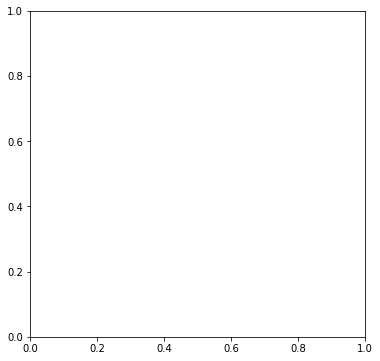

In [6]:
import math

# setup the plot
fig, ax = plt.subplots(1,1, figsize=(6,6))

# define the data
x = dates 
y = busier_line
labels = busier_line_names

N = len(set(labels))

# define the colormap
cmap = plt.cm.jet

# extract N colors from the .jet scale
colors = [cmap(i+int(cmap.N/N/2)) for i in range(cmap.N) if i%math.ceil(cmap.N/N)==0]

#map colors to labels
color_map={}
for i, label in zip(range(N), set(labels)):
    color_map[label]=colors[i]

bar = ax.bar(x,y,color=[color_map[label] for label in labels])

#Plot invisible bar graph but have the legends specified
for label, color in color_map.items(): 
    ax.bar(x, y,width=0,color=color, label=label) 

ax.legend()

plt.show()

In [ ]:
#Busier lines in weekends

## Finding trends accross months

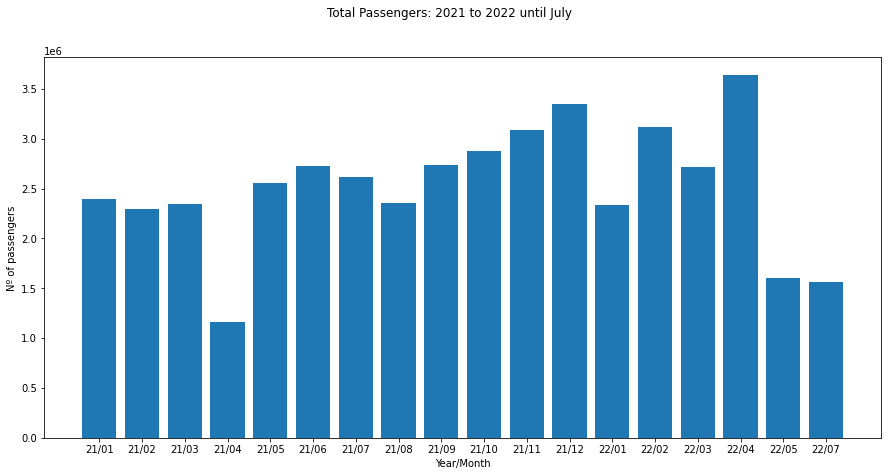

In [163]:
# for date in stats.keys():
#     print(f'Total passengers from ({date}) is {stats[date]["passenger_total"]} passengers.')
dates = list(stats.keys())
dates.sort()

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot()
total_passengers = []
for date in dates:
    total_passengers.append(stats[date]['passenger_total'])
    plt.suptitle('Total Passengers: 2021 to 2022 until July')
new_dates = [d.replace('_', '/') for d in dates]
dates = new_dates
plt.bar(dates, total_passengers)
plt.xlabel('Year/Month')
plt.ylabel("Nº of passengers")
plt.savefig('passengers_month.jpeg')
plt.show()    

# Get graph generated and perform analysis

In [ ]:
G = nx.read_gexf('../graph.gexf')

# Remove zero degree nodes
zero_degree_nodes = [n for n, d in G.degree if d == 0]
G.remove_nodes_from(zero_degree_nodes)


# plot(G)
# degree_analysis(G)
# connected_components_analysis(G)
# bridge_analysis(G)
# spanning_tree(G)
# voronoi_cells(G)
# betweeness_centrality(G)

print(f"Average Clustering Coefficient: {nx.average_clustering(G)}")
print(f"Degree Assortativity Coefficient: {nx.degree_assortativity_coefficient(G)}")

# Summarization
# G_summarized, _ = nx.dedensify(G, threshold=2)
# print(f"{G_summarized}")

## Busier lines and peak hour